In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.17.0


In [3]:
import pathlib

# TODO: write the paths of the datasets
data_dir = "/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI"
input_dir = f"{data_dir}/input"
gt_dir = f"{data_dir}/GT"

input_path = tf.io.gfile.glob(os.path.join(input_dir, "*.jpg"))
gt_path = tf.io.gfile.glob(os.path.join(gt_dir, "*.jpg"))

input_path = sorted(input_path)
gt_path = sorted(gt_path)

In [4]:
for i in range(5):
    print(f"Input: {input_path[i]} Label: {gt_path[i]}")

Input: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input/0.jpg Label: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT/0.jpg
Input: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input/1.jpg Label: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT/1.jpg
Input: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input/10.jpg Label: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT/10.jpg
Input: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input/100.jpg Label: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT/100.jpg
Input: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input/1000.jpg Label: /kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT/1000.jpg


In [5]:
batch_size = 32
img_height = 128
img_width = 128

In [6]:
assert len(input_path) == len(gt_path)

ds_input = tf.data.Dataset.from_tensor_slices(input_path)
gt_path  = tf.data.Dataset.from_tensor_slices(gt_path)

ds = tf.data.Dataset.zip(ds_input, gt_path)

In [7]:
DATASET_SIZE = len(input_path)

# Split the dataset into 80% for training and 20% for validation/dev set
val_size = int(DATASET_SIZE * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

In [8]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

3424
855


In [9]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [10]:
def process_path(input_path, gt_path):
    # Load the raw data from the file as a string
    input_img = tf.io.read_file(input_path)
    gt_img = tf.io.read_file(gt_path)
    
    input_img = decode_img(input_img)
    gt_img = decode_img(gt_img)
    return input_img, gt_img

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (128, 128, 3)
Label:  (128, 128, 3)


In [13]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [14]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

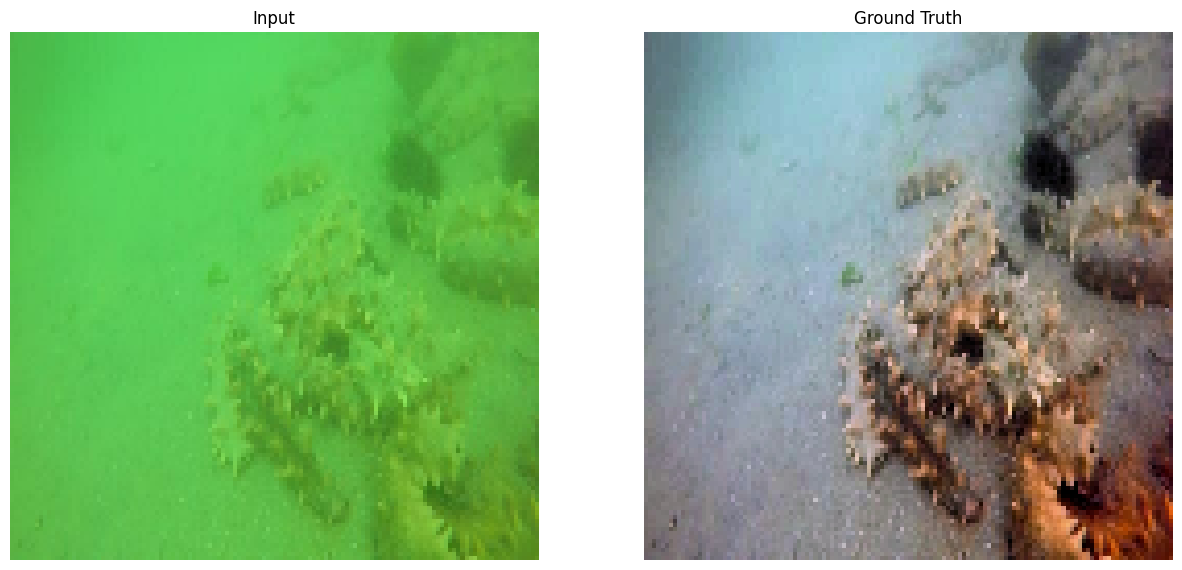

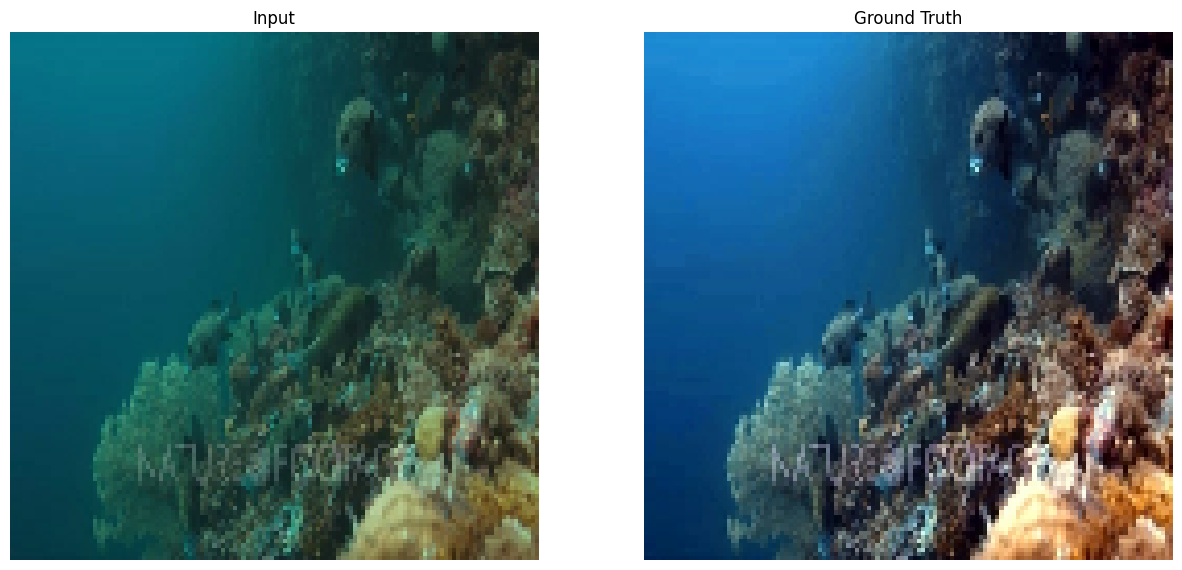

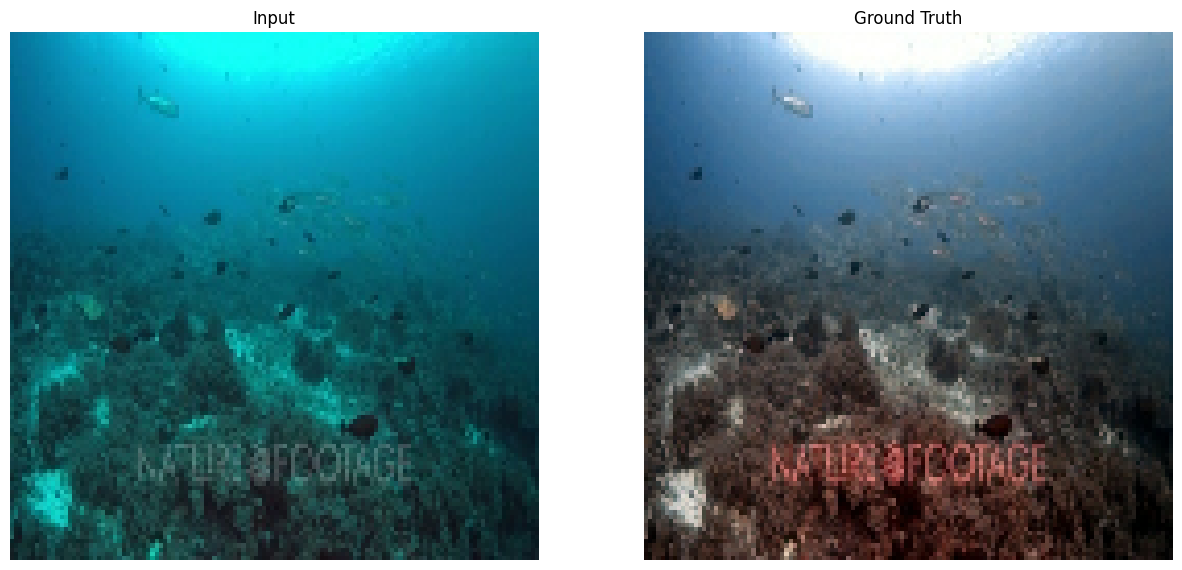

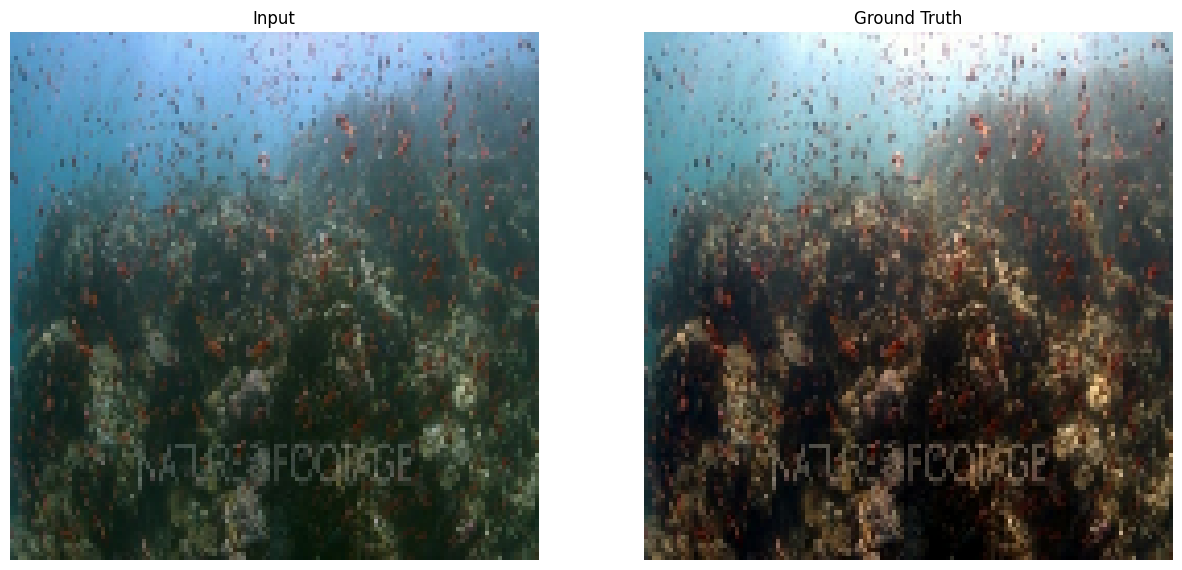

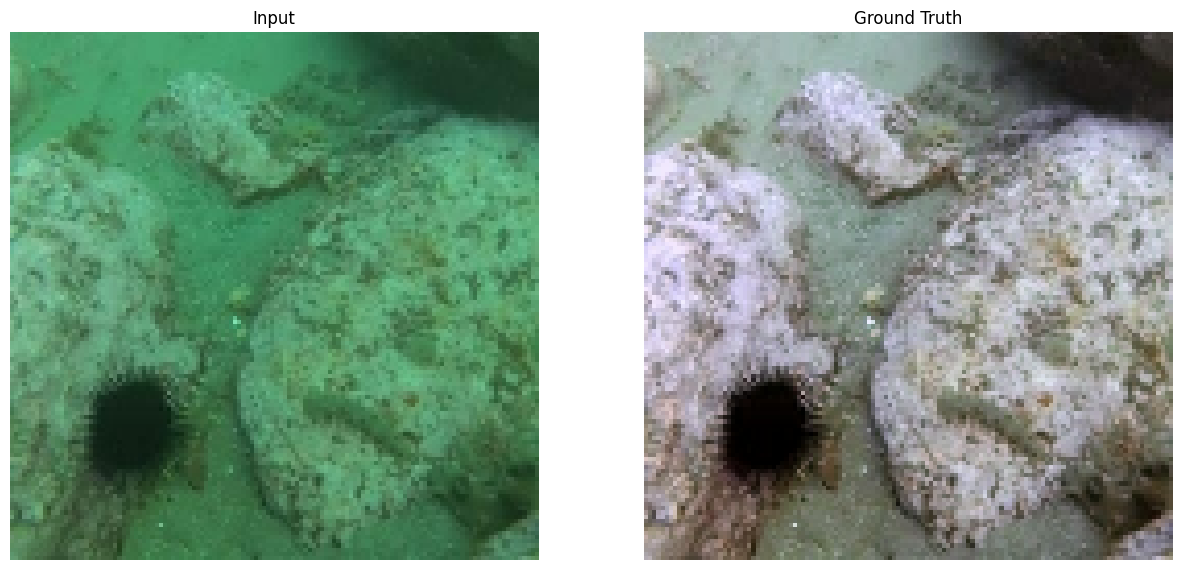

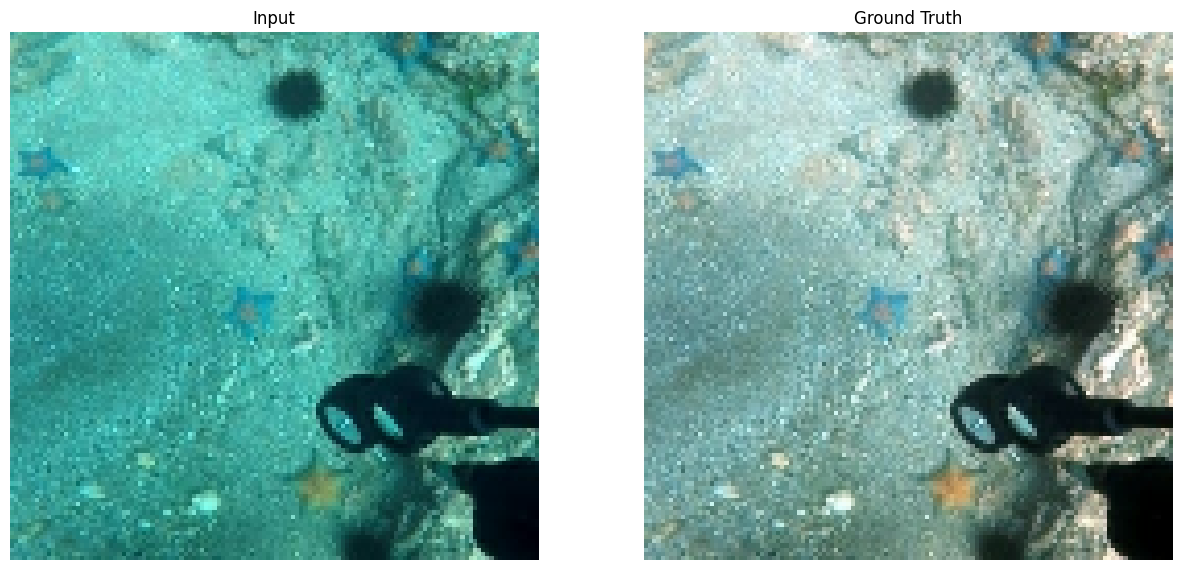

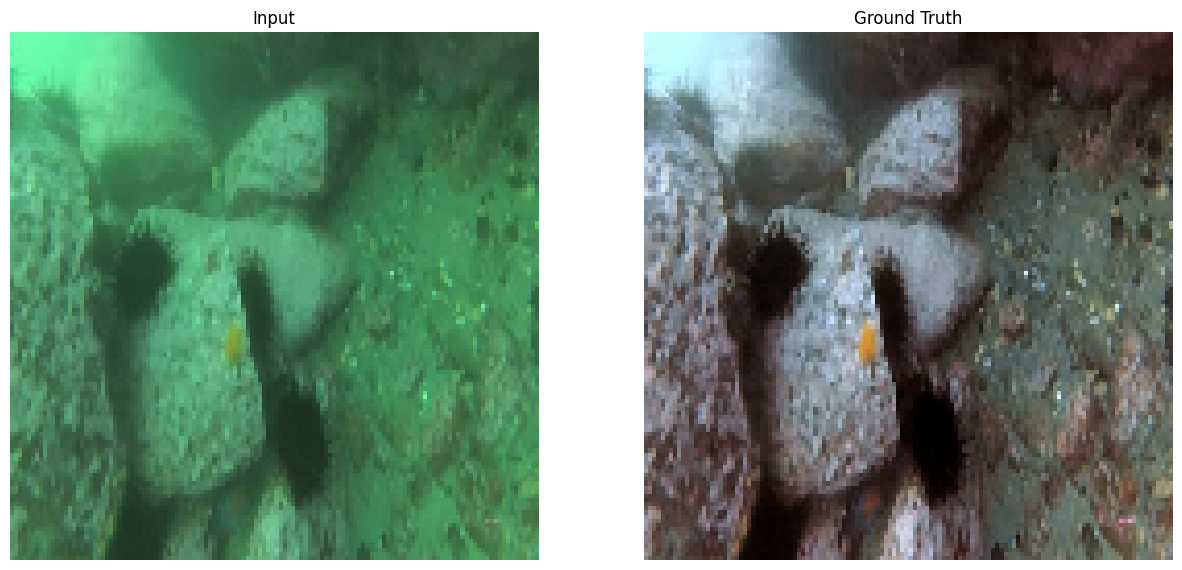

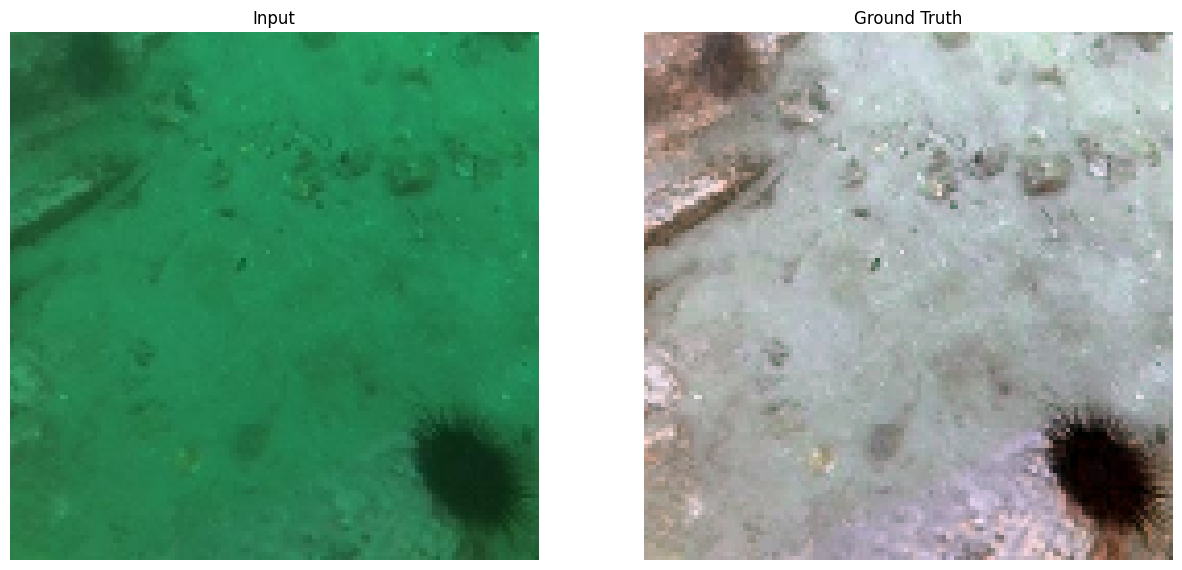

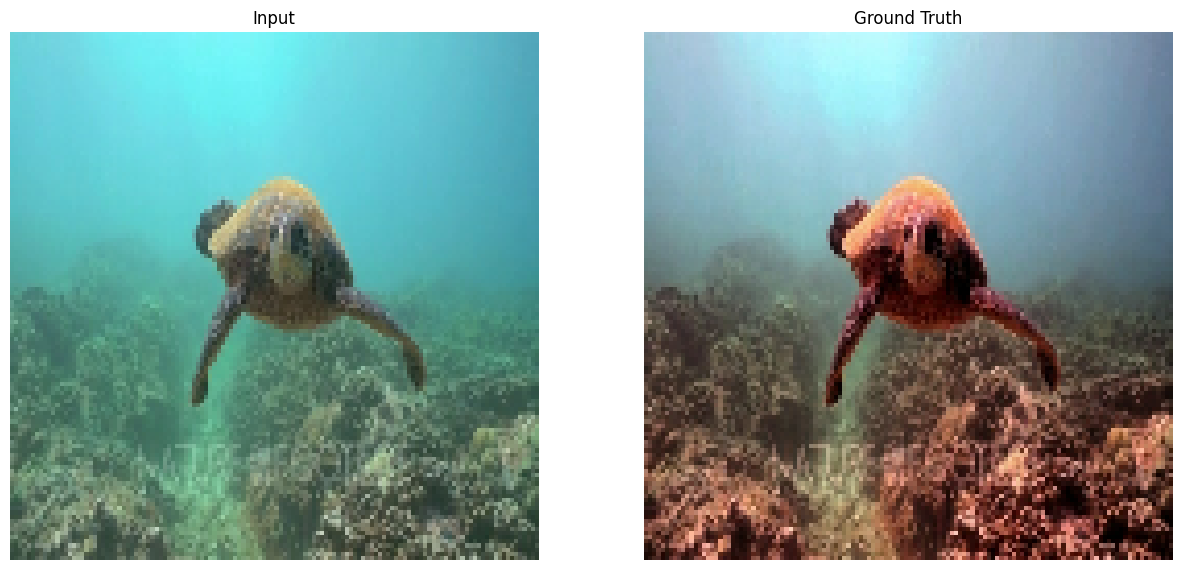

In [15]:
import matplotlib.pyplot as plt

image_batch, gt_batch = next(iter(train_ds))

for i in range(9):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title('Input')
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(gt_batch[i].numpy().astype("uint8"))
    plt.title('Ground Truth')
    plt.axis("off")
    plt.show()